## Feature Extraction, New and Improved

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
from pathlib import Path
from sklearn.model_selection import train_test_split
from pydub import AudioSegment
from scipy.fftpack import fft, dct

---

## Visualize audio data with librosa

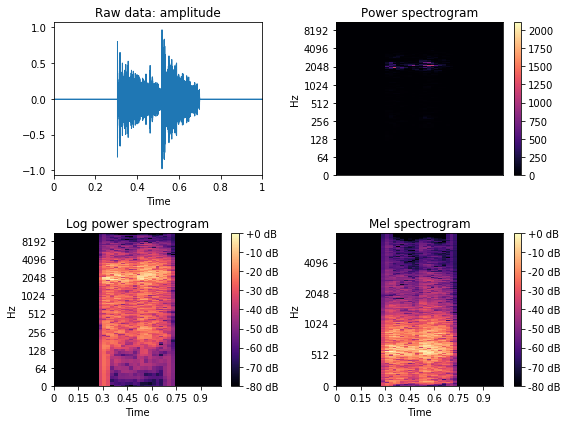

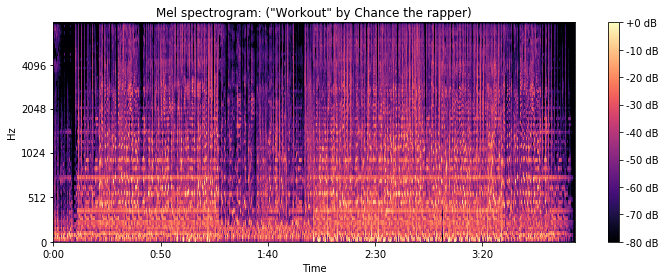

In [61]:
y, sr = librosa.load('../../../Source/Shuffle_test/1/1_pad.wav')
D = np.abs(librosa.stft(y))

# Using left-aligned frames
D_left = np.abs(librosa.stft(y,center=False))

# Using a shorter hop length
n_fft = 2048 # default 2048
D_short = np.abs(librosa.stft(y, n_fft=n_fft,hop_length=64)) # defaults to win_length(or n_fft)/4.



#librosa.display.specshow(D_left);
#librosa.display.specshow(D_short);

# Wave plot
plt.figure(figsize=(8,6))
plt.subplot(221)
librosa.display.waveplot(y, sr=sr)
plt.title('Raw data: amplitude')

# Power spectrogram with abs(stft(y))^2
plt.subplot(222)
librosa.display.specshow(D**2, sr=sr, y_axis='log')
plt.colorbar()
plt.title('Power spectrogram')

# Log power with power_to_db
plt.subplot(223)
librosa.display.specshow(librosa.power_to_db(D**2,ref=np.max),sr=sr, y_axis='log', x_axis='time')
plt.title('Log power spectrogram')
plt.colorbar(format='%+2.0f dB')

# Mel spectrogram 
plt.subplot(224)
librosa.display.specshow(librosa.power_to_db(D**2,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram');
plt.tight_layout()



y, sr = librosa.load('../../../workout.wav')
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D)


plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(S,ref=np.max),
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram: ("Workout" by Chance the rapper)')
plt.tight_layout()

---

## Pad samples with zeros to create equal length

In [ ]:
path_col = []
#pathlist = Path('../../../Source/Clean_train_clips/Re_augmented_pad').glob('**/*.wav')
#pathlist = Path('../../../Source/Clean_train_clips/Test_pad').glob('**/*.wav')
for path in pathlist:
    path_col.append(path)

In [ ]:
# Test Data 
#X_reserve = pd.read_csv('../../../Source/Data/X_test_reserved.csv')


#path_col = []
#for i in range (len(X_reserve)):
#    path_col.append(Path(X_ddd.loc[i,'Path']))
#

In [ ]:
#path_col
len(path_col)

In [ ]:
length_list = []
for i in range (len(path_col)):
    samples, sample_rate = librosa.load(path_col[i])
    length_list.append(len(samples))
max_length = max(length_list)
print(max_length)

In [ ]:
def pad_signal(path, length):
    samples, sample_rate = librosa.load(path)
    #name = str(path)[:34] + "Test_pad/" + str(path)[34:]
    #name = path
    if len(samples) < length:
        y = librosa.util.pad_center(samples, length ,axis=0) 
    else:
        y = samples
    return librosa.output.write_wav(path=name, y=y, sr=sample_rate)

In [ ]:
# Pad with silence and resave (saving over file)
#max_length = 20772
#for i in range(len(path_col)):
#    pad_signal(path_col[i], max_length)

In [ ]:
# Check if it worked
for path in path_col:
    samples, sample_rate = librosa.load(path)
    print(librosa.core.get_duration(y=samples, sr=sample_rate))


---

# Feature Extraction: exploration
## Tempo

Let's try it with a stretched and unstretched sample

In [ ]:
fast_clip = ('../../../Source/Clean_train_clips/Shuffle/1/1.wav')
slow_clip = ('../../../Source/Clean_train_clips/Augmented/Shuffle/1/1_stretch.wav') 

In [ ]:
def get_features_bpm(path): 
    samples, sample_rate = librosa.load(path)
    onset_env = librosa.onset.onset_strength(samples, sr=sample_rate) # Assumes static tempo, for dynamic: aggregate=None
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sample_rate)
    return tempo.item()


In [ ]:
get_features_bpm(slow_clip), get_features_bpm(fast_clip)

## Short-time Fourier transform (STFT)

From librosa documentation: <br/>
Returns a complex-valued matrix D such that
np.abs(D[f, t]) is the magnitude of frequency bin f at frame t

In [ ]:
n_fft = 2048 # default 2048


In [ ]:
def get_features_stft (path):
        y, sr = librosa.load(path)
        D = np.abs(librosa.stft(y))
        return D

## Mel-frequency cepstral coefficients 

In [2]:
n_mfcc = 20 

In [3]:
def get_features_mfcc(path):
    samples, sample_rate = librosa.load(path)
    mfccs = np.mean(librosa.feature.mfcc(y=samples, sr=sample_rate, n_mfcc=n_mfcc).T,axis=0)
    return mfccs

## Zero crossing rate
Use with padded samples of equal length

In [4]:
def get_features_ZCR(path):
    samples, sample_rate = librosa.load(path)
    return librosa.feature.zero_crossing_rate(samples, frame_length=250, hop_length=125)

In [5]:
test_path = ('../../../Source/Clean_train_clips/Test_pad/Shuffle/1/10.wav')
#test_path = ('../../../Source/Clean_train_clips/Re_augmented_pad/Shuffle/1/1_.wav')

In [6]:
zcr_length = get_features_ZCR(test_path).shape[1]

In [7]:
zcr_length

167

## Energy and Root Mean Square Energy

In [33]:
x, sr = librosa.load('../../../Source/Clean_train_clips/Re_augmented_pad/Shuffle/1/1_.wav')
print ('Duration in sec: ' + str(librosa.core.get_duration(x,sr)))
print('Length of sample: ' + str(len(x)))

Duration in sec: 0.9420408163265306
Length of sample: 20772


In [51]:
hop_length = 256
frame_length = 512

In [48]:
def get_features_energy(path) :
    samples, sample_rate = librosa.load(path)
    energy = np.array([sum(abs(samples[i:i+frame_length]**2)) for i in range (0, len(samples), hop_length)])
    return energy

def get_features_rmse(path):
    samples, sample_rate = librosa.load(path)
    rmse = librosa.feature.rmse(samples, frame_length=frame_length, hop_length=hop_length, center=True)
    return rmse[0]

In [50]:
# Could this be an option to reduce features? Does this make sense?

frame_length = int(len(x))
hop_length = int(frame_length/2)
print (frame_length, hop_length)
get_features_energy('../../../Source/Clean_train_clips/Re_augmented_pad/Shuffle/1/5_.wav')

array([157.53244661,  93.87143679])

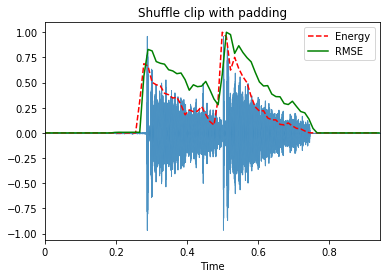

In [59]:
# So the shape of the energy and RMSE is the result of # of samples / (frame_length/2) +1
energy = get_features_energy('../../../Source/Clean_train_clips/Re_augmented_pad/Shuffle/1/1_.wav')
rmse = get_features_rmse('../../../Source/Clean_train_clips/Re_augmented_pad/Shuffle/1/1_.wav')
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length) # Why?
# Visualization
#plt.figure(figsize=(8,6))
librosa.display.waveplot(x, sr=sr, alpha=0.8)
plt.plot(t, energy/energy.max(), 'r--')             # normalized for visualization
plt.plot(t[:len(rmse)], rmse/rmse.max(), color='g') # normalized for visualization
plt.legend(('Energy', 'RMSE'))
plt.title('Shuffle clip with padding');

---

## Feature Extraction: implementation
(Organized in a DataFrame)

In [8]:
def build_list(step, folder, length):
    i = 1
    step_list = []
    while i <= length :
        name = step + "/" + str(folder) + "/" +str(i) + ".wav"
        step_list.append(name)
        i += 1
    return step_list

def get_label(path):
    if path.parts[-3] == 'Shuffle':
        return 1
    else:
        return 0

---

### Load Training Data

In [9]:
shuffle_col, bc_col, path_col = [], [], []

In [10]:
#pathlist = Path('../../../Source/Clean_train_clips/Re_augmented_pad/Shuffle').glob('**/*.wav')
pathlist = Path('../../../Source/Clean_train_clips/Test_pad/Shuffle').glob('**/*.wav')
for path in pathlist:
    shuffle_col.append(path)
    shuffle_col.sort()

In [11]:
#pathlist = Path('../../../Source/Clean_train_clips/Re_augmented_pad/Ball_change').glob('**/*.wav')
pathlist = Path('../../../Source/Clean_train_clips/Test_pad/Ball_change').glob('**/*.wav')
for path in pathlist:
    bc_col.append(path)
    bc_col.sort()

In [ ]:
#untrans_path_col = []
#train_untransform = pd.read_csv('../../../Source/Data/X_train_preAugmented.csv')
#for i in range ( len(train_untransform)):
#    untrans_path_col.append(Path(train_untransform.loc[i, 'Path']))

In [12]:
path_col = shuffle_col + bc_col #+ untran's_path_col

In [13]:
len(path_col) # Train: 912, Test: 115

115

** Create DataFrame from file paths **

In [14]:
tap = pd.DataFrame({'Path':path_col})
tap.shape

(115, 1)

---

### OR load (reserved) Test Data

In [ ]:
#test_data = pd.read_csv('../../../Source/Data/X_test_reserved.csv')
#test_labels = pd.read_csv('../../../Source/Data/y_test_reserved.csv')

In [ ]:
# tap = test_data

---

**Add labels**

In [15]:
tap['Labels'] = [get_label(tap.loc[idx,'Path']) for idx in range(len(tap))]

In [16]:
tap.head()

,Path,Labels
0,../../../Source/Clean_train_clips/Test_pad/Shu...,1
1,../../../Source/Clean_train_clips/Test_pad/Shu...,1
2,../../../Source/Clean_train_clips/Test_pad/Shu...,1
3,../../../Source/Clean_train_clips/Test_pad/Shu...,1
4,../../../Source/Clean_train_clips/Test_pad/Shu...,1


** Empty Dataframe to fill**

In [17]:
# Create an empty dataframe to fill with multiple feature values

d = pd.DataFrame(np.zeros((len(tap), int(n_mfcc+zcr_length))))
tap = pd.concat([tap, d], axis=1)

In [18]:
tap.shape
#int(20+167+82+82)
#20+2+167+82

(115, 189)

**Add Features: MFCCs**

In [ ]:
# TOO SLOW!
#for i in range (n_mfcc):
#    tap[str(i)] = [get_features_mfcc(tap.loc[idx, 'Path'])[i] for idx in range (len(tap))]

In [ ]:
# Create an empty dataframe to fill with MFCC values
d = pd.DataFrame(np.zeros((len(tap), n_mfcc)))
tap = pd.concat([tap, d], axis=1)

In [19]:
# Add feature to DataFrame
for j in range (len(tap))  :  
    s = get_features_mfcc(tap.loc[j,'Path'])
    for i in range (n_mfcc):
        tap.iat[j,i+2] = s[i]

In [21]:
tap.head()
#tap.iloc[:,20:]
#tap.iat[0,0+22]

,Path,Labels,0,1,2,3,4,5,6,7,...,177,178,179,180,181,182,183,184,185,186
0,../../../Source/Clean_train_clips/Test_pad/Shu...,1,-335.976138,43.414944,-68.477188,21.008180,-4.408123,-2.970243,-19.639680,-0.455080,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,../../../Source/Clean_train_clips/Test_pad/Shu...,1,-351.007970,40.109784,-63.794729,23.560631,-2.753592,-0.453999,-15.169304,-3.271940,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,../../../Source/Clean_train_clips/Test_pad/Shu...,1,-497.674053,19.656596,-27.546274,10.032751,-4.512792,0.937636,-7.593287,1.180707,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,../../../Source/Clean_train_clips/Test_pad/Shu...,1,-367.690502,42.046789,-42.360295,15.060588,-14.119677,7.645445,-11.598609,-0.446276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,../../../Source/Clean_train_clips/Test_pad/Shu...,1,-370.150079,49.300692,-44.129399,14.314299,-7.690344,3.293678,-19.717559,-2.202616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


** Add Features: Tempo**

In [ ]:
tap['BPM'] = [get_features_bpm(tap.loc[idx, 'Path']) for idx in range (len(tap))]

** Add features: Zero-crossing rate**

In [ ]:
# Create an empty dataframe to fill with ZCR values
zcr_length = zcr_length
d = pd.DataFrame(np.zeros((len(tap), zcr_length)))
#tap = pd.concat([tap, d], axis=1)

In [22]:
for j in range (len(tap))  :  
    s = get_features_ZCR(tap.loc[j,'Path'])[0]
    for i in range (zcr_length):
        tap.iat[j,i+22] = s.item(i)

In [23]:
tap.head()
tap.shape

(115, 189)

**Add features: Short-time Fourier Transform**

In [ ]:
# Create an empty dataframe to fill with STFT values
d = pd.DataFrame(np.zeros(len(tap), (int(n_fft/2+1))))
tap = pd.concat([tap, d], axis=1)

In [ ]:
for j in range (len(tap))  :  
    s = get_features_stft(tap.loc[j,'Path'])[0]
    for i in range (int(n_fft/2+1)):
        tap.iat[j,i+2] = s.item(i)

In [ ]:
tap.head()

**Add Features: Energy **

In [ ]:
# Create an empty dataframe to fill with energy values
#x, sr = librosa.load('../../../Source/Clean_train_clips/Re_augmented_pad/Shuffle/1/1_.wav')
x, sr = librosa.load('../../../Source/Clean_train_clips/Test_pad/Shuffle/1/10.wav')
length = int(len(x)/(frame_length/2)+1)
## Assume all clips of equal length to above
#d = pd.DataFrame(np.zeros((len(tap), length)))
#tap = pd.concat([tap, d], axis=1)
length

In [ ]:
for j in range (len(tap))  :  
    s = get_features_energy(tap.loc[j,'Path'])
    for i in range (int(len(x)/(frame_length/2)+1)):
        tap.iat[j,i+189] = s.item(i)

In [ ]:
#tap.iloc[:,55:100]
tap.head()

**Add Features: Root mean square energy **

In [ ]:
# Create an empty dataframe to fill with RMSE values
#x, sr = librosa.load('../../../Source/Clean_train_clips/Re_augmented_pad/Shuffle/1/1_.wav')
x, sr = librosa.load('../../../Source/Clean_train_clips/Test_pad/Shuffle/1/10.wav')
length = int(len(x)/(frame_length/2)+1)
# Assume all clips of equal length to above
d = pd.DataFrame(np.zeros((len(tap), length)))
tap = pd.concat([tap, d], axis=1)

In [ ]:
for j in range (len(tap))  :  
    s = get_features_rmse(tap.loc[j,'Path'])
    for i in range (int(len(x)/(frame_length/2)+1)):
        tap.iat[j,i+271] = s.item(i)

In [ ]:
tap.head()
#tap.iloc[:,55:100]

----

### Export Feature DataFrame

In [24]:
tap = tap.sample(frac=1)
tap.head()

,Path,Labels,0,1,2,3,4,5,6,7,...,177,178,179,180,181,182,183,184,185,186
102,../../../Source/Clean_train_clips/Test_pad/Bal...,0,-271.529746,38.751784,-44.909944,20.786623,-16.545922,6.570188,-11.211985,0.585136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
96,../../../Source/Clean_train_clips/Test_pad/Bal...,0,-276.614255,48.996501,-39.491205,14.414297,-19.430250,10.220102,-11.194749,-4.013218,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,../../../Source/Clean_train_clips/Test_pad/Shu...,1,-388.991649,60.032330,-36.081503,15.707447,-10.021751,0.735541,-12.575030,-3.220611,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
83,../../../Source/Clean_train_clips/Test_pad/Bal...,0,-303.853425,50.866604,-36.237409,15.946713,-12.248871,6.621641,-11.523458,-0.451680,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99,../../../Source/Clean_train_clips/Test_pad/Bal...,0,-404.904766,37.125855,-30.456610,14.460039,-16.038932,3.589025,-8.337439,-5.494876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Train
#tap.to_csv('../../../Source/Data/train_data_reaugmented_pad_mfcc_zcr.csv', index=None)

# Test
#tap.to_csv('../../../Source/Data/TEST_data_pad_mfcc_zcr.csv', index=None)

### Split into inputs and labels (and train and validate)

In [26]:
X = tap.drop(['Labels'], axis =1)
y = tap[['Labels']]

In [ ]:
#X_train, X_val, y_train, y_val = train_test_split(X, y,
#                                                    stratify=y, 
#                                                    test_size=0.25)

In [27]:
X_train = pd.DataFrame(X)
y_train = pd.DataFrame(y)

#X_val = pd.DataFrame(X_val)
#y_val = pd.DataFrame(y_val)



In [28]:
# Export training data
#X_train.to_csv('../../../Source/Data/X_train_audio_reaugmented_pad_mfcc_zcr.csv', index=None)
#y_train.to_csv('../../../Source/Data/y_train_audio_reaugmented_pad_mfcc_zcr.csv', index=None)

# Export validation data
#X_val.to_csv('../../../Source/Data/X_val_audio_augmented_.csv', index=None)
#y_val.to_csv('../../../Source/Data/y_val_audio_augmented_.csv', index=None)

# Export test data
#X_train.to_csv('../../../Source/Data/X_test_audio_pad_mfcc_zcr.csv', index=None)
#y_train.to_csv('../../../Source/Data/y_test_audio_pad_mfcc_zcr.csv', index=None)

## TBD "Features"

**Add features: Fast Fourier Transform**

In [ ]:
def get_features_fft(path):
    y, sr = librosa.load(path)
    return np.mean(fft(y).real)

#tap['FFT'] = [get_features_fft(tap.loc[idx, 'Path']) for idx in range (len(tap))]

**Add features: Discrete cosine transform**

In [ ]:
def get_features_dct(path):
    y, sr = librosa.load(path)
    return (dct(y))

#tap['DCT'] = [get_features_dct(tap.loc[idx, 'Path']) for idx in range (len(tap))]

**Other (maybe useful) stuff from librosa**

In [ ]:
librosa.core.get_duration(y=y, sr=sr) # Get duration in seconds

** Other code to consider/incorporate ** 

In [ ]:
def extract_feature(file_name):
    X, sample_rate = librosa.load(file_name)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast,tonnetz

## Trying out stuff

In [ ]:
# Can I make a better graph by splitting differently? 
# Tested out in Data_Collection_Audio, ultimately ending with detect nonsilence method, then padding
samples, sample_rate = librosa.load('../../../Source/Shuffle_test/1/1.wav')
librosa.display.waveplot(samples, sr=sample_rate);



In [ ]:
# Pad with silence
padded_signal = librosa.util.pad_center(samples, 22050, axis=0) # Make clip 1 sec long
sound_clip = padded_signal
librosa.display.waveplot(sound_clip, sr=sample_rate);
#librosa.output.write_wav('../../../Source/Shuffle_test/1/1_pad.wav', padded_signal, 22050)

In [ ]:
def windows(data, window_size):
    start=0
    while start < len(data):
        yield start, start + window_size
        start += (window_size/2)

In [ ]:
i = 0
for (start, end) in windows(sound_clip, window_size):
    i +=1
print(i)

In [ ]:
log_specgrams = []
window_size = 100 * 60
sound_clip = padded_signal
bands = 41
frames = 60

In [ ]:
for (start, end) in windows(sound_clip, window_size):
    if len(sound_clip[int(start):int(end)]) == (window_size):
        signal = sound_clip[int(start):int(end)]
        melspec = librosa.feature.melspectrogram(signal,n_mels=bands)
        logspec = librosa.amplitude_to_db(melspec)
        logspec = logspec.T.flatten()[:, np.newaxis].T
        log_specgrams.append(logspec)
        
log_specgrams = np.array(log_specgrams)
print(log_specgrams.shape) #  This is (# of complete windows, 1, # of bands)
#log_specgrams = np.asarray(log_specgrams).reshape(log_specgrams.shape[0], bands, frames)

